# Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from PIL import Image

#Torch

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
#Torch model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Processing



### Upload data to colab

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
!gdown --id 1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh

Traceback (most recent call last):
  File "C:\Users\OC\.conda\envs\cv\Lib\site-packages\requests\compat.py", line 11, in <module>
    import chardet
ModuleNotFoundError: No module named 'chardet'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\OC\.conda\envs\cv\Scripts\gdown.exe\__main__.py", line 4, in <module>
  File "C:\Users\OC\.conda\envs\cv\Lib\site-packages\gdown\__init__.py", line 4, in <module>
    from .cached_download import cached_download
  File "C:\Users\OC\.conda\envs\cv\Lib\site-packages\gdown\cached_download.py", line 12, in <module>
    from .download import download
  File "C:\Users\OC\.conda\envs\cv\Lib\site-packages\gdown\download.py", line 13, in <module>
    import requests
  File "C:\Users\OC\.conda\envs\cv\Lib\site-packages\requests\__init__.py", line 45, in <module>
    from .exceptio

In [4]:
!unzip /content/wb_recognition_dataset.zip &> /dev/null

The syntax of the command is incorrect.


In [5]:
cnv_local_dir = 'wb_recognition_dataset/wb_recognition_dataset'
colab_dir = '/content/wb_recognition_dataset'
dataset_dir = cnv_local_dir
train_dataset_dir = dataset_dir + '/train'
val_dataset_dir = dataset_dir + '/val'
val_dataset_img_dir = val_dataset_dir + '/images'
annotations_file_dir = val_dataset_dir + '/labels.csv'


In [6]:
# %cd train_dataset
image_folders = os.listdir(train_dataset_dir)
print(image_folders)

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '1110', '1111

In [7]:
print(len(image_folders))
print(max(image_folders))

2139
999


### Data Pre-processing

In [8]:

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

alexnet_transform = transforms.Compose([
    transforms.Resize((227,227)),                  # Resize the image to 256x256
    # transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),              # Perform a center crop to obtain a square 224x224 image
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

basic_minist = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

sameSize_transform = transforms.Compose([
    transforms.ToTensor()
])


### Load Train and Valid data from directory

In [31]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = self.img_labels.iloc[:, 1].unique().tolist()
        self.targets = self.img_labels.iloc[:, 1].tolist()
        # self.data = [os.path.join(self.img_dir, img) for img in self.img_labels.iloc[:, 0].tolist()]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = str(self.img_labels.iloc[idx, 0]) + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

#### Sample Data (MINIST)

In [10]:
mnist_transform = sameSize_transform

mnist_train = datasets.MNIST(
    root = 'data',
    train = True,
    transform = mnist_transform,
    download = True
)

mnist_test = datasets.MNIST(
    root = 'data',
    train = False,
    transform = mnist_transform,
    download = True
)

In [11]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [33]:
chosen_transform = basic_minist

# train_dataset = CustomImageFolder(
#     root=train_dataset_dir, 
#     transform=chosen_transform)

train_dataset = datasets.ImageFolder(
    root=train_dataset_dir, 
    transform=chosen_transform)

valid_dataset = CustomImageDataset(
    annotations_file = annotations_file_dir,
    img_dir = val_dataset_img_dir,
    transform = chosen_transform
    )

FileNotFoundError: Found no valid file for the classes 1131, 1212, 1221, 1376, 1632, 1785, 1854, 509, 643. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [32]:
def find_missing_labels(dataset):
    all_labels = set(range(len(dataset.classes)))  # Assuming labels are integers from 0 to num_classes-1
    present_labels = set(map(int, dataset.classes))
    missing_labels = all_labels - present_labels
    return missing_labels

# Example usage:
missing_labels = find_missing_labels(train_dataset)
print("Missing labels:", missing_labels)

ValueError: invalid literal for int() with base 10: '0 - zero'

In [15]:
train_dataset = mnist_train
valid_dataset = mnist_test

Image shape: torch.Size([1, 28, 28])
Label: 7


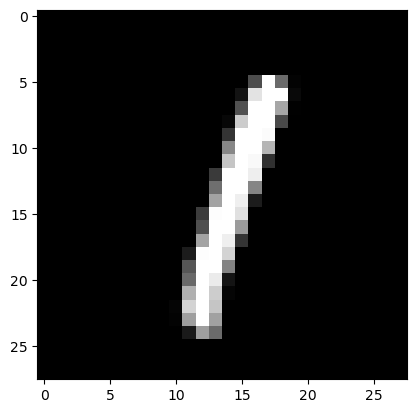

In [16]:
testing_sample_set = valid_dataset
testing_sample_set[0]
# Accessing a single sample
sample_image, sample_label = testing_sample_set[0]
print("Image shape:", sample_image.shape)      # Shape of the image tensor
print("Label:", sample_label)
plt.imshow(testing_sample_set[5][0].permute(1, 2, 0), cmap='gray')

#### DataLoader


In [17]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

Batch 0:
Batch Size: 64
Labels (First five):  tensor([0, 1, 7, 6, 3])


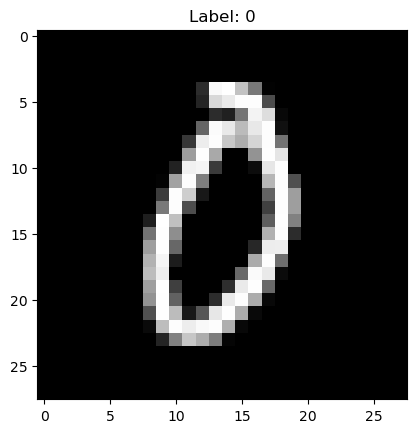

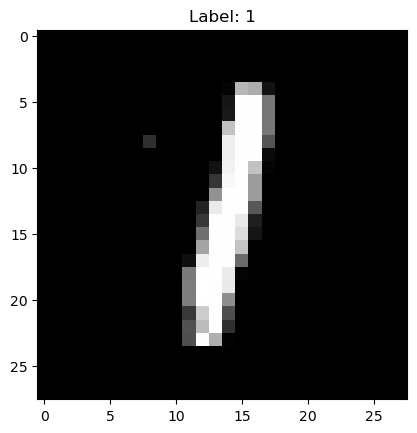

In [18]:
# Iterate over batches in the train loader
for i, (data, labels) in enumerate(train_loader):
    # Print batch size and labels
    print(f"Batch {i}:")
    print("Batch Size:", data.size(0))
    print("Labels (First five): ", labels[:5])

    # Visualize some sample images (optional)
    for i in range(min(2, data.size(0))):  # Visualize up to 4 images from each batch
        plt.imshow(data[i].permute(1, 2, 0).squeeze().numpy(), cmap='gray')  # Convert tensor to numpy array
        plt.title(f"Label: {labels[i]}")
        plt.show()

    break
    # Break after the first batch for demonstration

# Model

### Model Architecture

#### Alexnet (Custom)
Input:
- 3 x 227 x 227

Output:

- 1000 (Base) -> 2130 (Adjusted)


In [19]:

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### Custom Model

In [20]:
# MNIST (1, 28, 28)
class CustomBuiltModel(nn.Module):
    def __init__(self, classes_num=10):
        super(CustomBuiltModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, classes_num)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



### Initiate Model

Note: Change the input data transform fuction accordingly to the chosen model


In [21]:
len(train_loader.dataset.classes)

10

In [22]:
output_classes_num = len(train_dataset.classes)
# output_classes_num = 2138
output_classes_num

10

In [ ]:
model = models.alexnet(weights='IMAGENET1K_V1')
# model = AlexNet(output_classes_num)
# model = CustomBuiltModel()
model = model.to(device)

# Traning



### Parameter

In [25]:
leaning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=leaning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.5, last_epoch=-1)
total_step = len(train_loader)

### Traning Loop

In [26]:
def train(epochs_num):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # # Compute the total loss for the batch and add it to train_loss
        # # train_loss += loss.item() * inputs.size(0)
        # train_loss += loss.item()


        # # Compute the accuracy
        # prediction_point, predictions_label = torch.max(outputs.data, 1)
        # correct_pred += predictions_label.eq(labels.data.view_as(predictions_label))

        # # Convert correct_counts to float and then compute the mean
        # acc = torch.mean(correct_pred.type(torch.FloatTensor))

        # # Compute total accuracy in the whole batch and add to train_acc
        # # train_acc += acc.item() * inputs.size(0)
        # train_acc += acc.item() * inputs.size(0)

        
        if i % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epochs_num, i * len(inputs), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))

In [27]:
def valid():

    model.eval()

    valid_loss = 0.0
    valid_acc = 0.0
    correct_pred = 0
    
    with torch.no_grad():
        for j, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            # valid_loss += loss.item() * inputs.size(0)
            valid_loss += loss.item()

            # Calculate validation accuracy
            prediction_point, predictions_label = torch.max(outputs.data, 1)
            correct_pred += predictions_label.eq(labels.data.view_as(predictions_label)).sum()

    valid_loss /= len(valid_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct_pred, len(valid_loader.dataset),
        100. * correct_pred / len(valid_loader.dataset)))  
        

            

In [28]:
epochs = 1
# history = []
valid()
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
    train(epochs)
    valid()

C:\Users\OC\AppData\Local\Temp\ipykernel_10208\195287542.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0362, Accuracy: 533/10000 (5%)

Epoch: 1/1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312339
Train Epoch: 1 [2048/60000 (3%)]	Loss: 1.436141
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.999457
Train Epoch: 1 [6144/60000 (10%)]	Loss: 0.532398
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.431787
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.841577
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.569266
Train Epoch: 1 [14336/60000 (24%)]	Loss: 0.432118
Train Epoch: 1 [16384/60000 (27%)]	Loss: 1.085364
Train Epoch: 1 [18432/60000 (31%)]	Loss: 0.541430
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.294531
Train Epoch: 1 [22528/60000 (38%)]	Loss: 0.497265
Train Epoch: 1 [24576/60000 (41%)]	Loss: 0.386612
Train Epoch: 1 [26624/60000 (44%)]	Loss: 0.415877
Train Epoch: 1 [28672/60000 (48%)]	Loss: 0.580542
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.852092
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.329989
Train Epoch: 1 [34816/60000 (58%)]	Loss: 0.409272
Train Epoch: 1 [36864/60000 (61%)]	Loss: 0.2